# Implementing ResNet in keras

if you hope to see [paper](https://arxiv.org/pdf/1512.03385.pdf)

![](https://iq.opengenus.org/content/images/2020/03/Screenshot-from-2020-03-20-15-49-54.png)  
I build 34-layer and 50-layer

In [1]:
from tensorflow import keras

In [2]:
def build_residual_block(input_layer,
                    stride = 1,
                    layer_cnt=[3, 4, 6, 3], 
                    channel=[64, 128, 256, 512],
                    block_num=1,
                    is_50=False,
                    plain=False
                   ):
    # 입력 레이어
    x = input_layer


    if is_50 is False:
        # 34-layer conv2_x 반복 블록 시작
        strides = [stride] + [1] * (layer_cnt - 1)
        # shortcut을 위한 identity x(x_cp)를 구성
        x_cp = x
        for stride in strides:
            # 각 conv2_x의 첫
            if stride != 1:
                x_cp = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1, 1),
                    padding='SAME', 
                    strides = stride
                )(x_cp)
                x_cp = keras.layers.BatchNormalization()(x_cp)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides = stride
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides=1
            )(x)
            x = keras.layers.BatchNormalization()(x)

            if plain is False :
                x = keras.layers.Add()([x_cp, x])
            else:
                pass
            x = keras.layers.Activation('relu')(x)
            x_cp = x
    else:
        # 50-layer conv2_x 반복 블록 시작
        strides = [stride] + [1] * (layer_cnt - 1)
        x_cp = x
        for stride in strides:
            if stride != 1:
                x_cp = keras.layers.Conv2D(
                    filters=4*channel,
                    kernel_size=(1, 1),
                    padding='SAME', 
                    strides = stride
                )(x_cp)
                x_cp = keras.layers.BatchNormalization()(x_cp)

            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1, 1),
                padding='SAME',
                strides = stride
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides=1
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=4*channel,
                kernel_size=(1, 1),
                padding='SAME',
                strides = 1
            )(x)
            x = keras.layers.BatchNormalization()(x)

            if plain is False :
                x = keras.layers.Add()([x_cp, x])

            x = keras.layers.Activation('relu')(x)
            x_cp = x
    return x

In [3]:
def build_resnet(input_shape=(32, 32, 3), is_50=False, plain=False):

    inputs = keras.layers.Input(shape=input_shape)

    # 공통 앞 부분 (conv1)
    x = keras.layers.Conv2D(64, 
                            kernel_size=7, 
                            padding='SAME', 
                            strides=2,
                            name='conv1_conv')(inputs)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)

    # 공통 앞 부분 (conv2)
    x = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        name=f'conv2_pooling')(x)

    if is_50 is False :
        # resnet_34 구현
        strides = [1, 2, 2, 2]
        channel_cnt = [64, 128, 256, 512]
        layer_cnt = [3, 4, 6, 3]
        for i, (l_cnt, channel, stride) in enumerate(zip(layer_cnt, channel_cnt, strides)):
            x = build_residual_block(
                x,
                stride = stride,
                layer_cnt=l_cnt, 
                channel=channel,
                block_num=i,
                is_50=False,
                plain=plain
            )
    else:
        # resnet_50 구현
        strides = [2, 2, 2, 2]
        channel_cnt = [64, 128, 256, 512]
        layer_cnt = [3, 4, 6, 3]
        for i, (l_cnt, channel, stride) in enumerate(zip(layer_cnt, channel_cnt, strides)):
            x = build_residual_block(
                x,
                stride = stride,
                layer_cnt=l_cnt, 
                channel=channel,
                block_num=i,
                is_50=True,
                plain=plain
            )
    
    # 공통 출력 부분
    output = keras.layers.GlobalAveragePooling2D()(x)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(5, activation='softmax')(output)

    model = keras.Model(
        inputs=inputs,
        outputs=output
    )

    return model

In [4]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False, plain=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

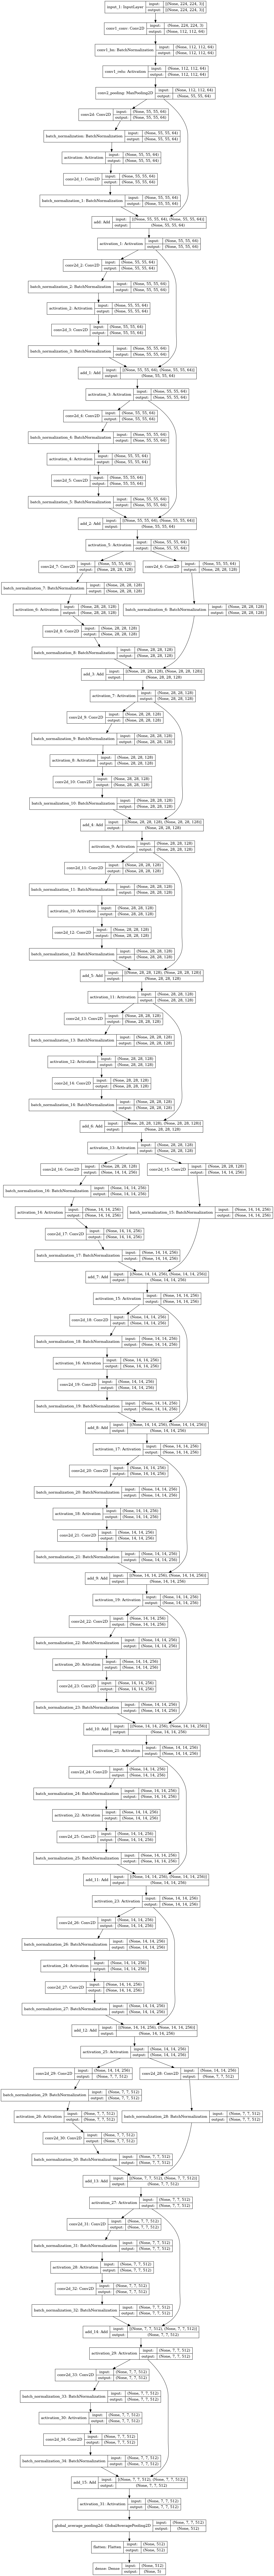

In [5]:
keras.utils.plot_model(resnet_34, show_shapes=True)

In [6]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True, plain=False)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 112, 112, 64) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

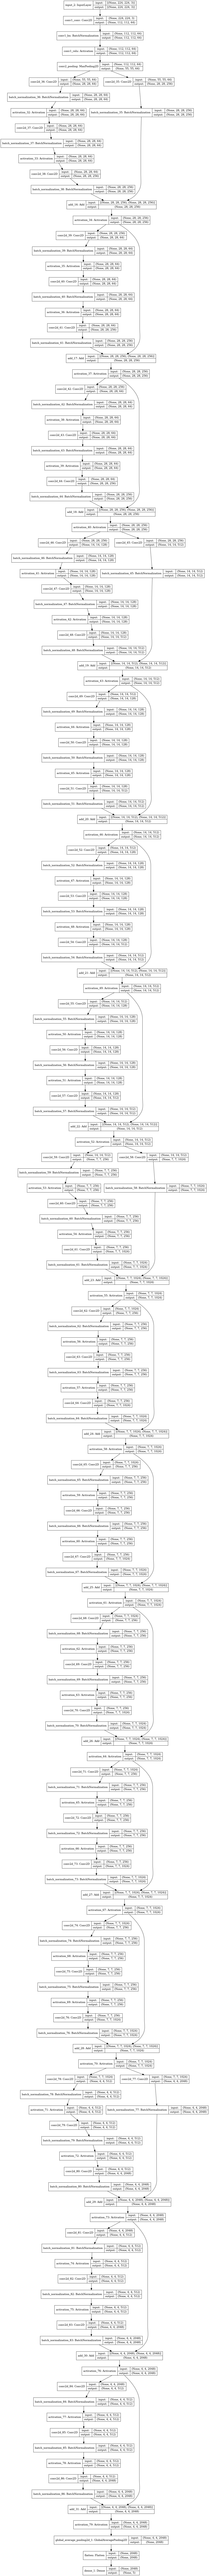

In [7]:
keras.utils.plot_model(resnet_50, show_shapes=True)


|항목|ResNet-34|ResNet-50|
|---|---|---|
|Total params| 21,312,773|23,597,957|
|Trainable params|21,295,749|23,544,837|
|Non-trainable params|17,024|53,120|

# Load the flowers dataset
![](https://www.tensorflow.org/static/hub/tutorials/image_feature_vector_files/output_1friUvN6kPYM_0.png?hl=ko) 

In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf

(raw_train, raw_validation, raw_test), ds_info = tfds.load(
    'tf_flowers', # 3.670 items
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
def normalize_and_resize_img(image, label):
    resized_images = tf.image.resize(image,(224, 224))
    return tf.cast(resized_images, tf.float32) / 255., label

In [11]:
BATCH_SIZE = 32
EPOCH = 50

In [12]:
ds_train = apply_normalize_on_dataset(raw_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(raw_test, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(raw_validation, batch_size=BATCH_SIZE)

## ResNet-34, ResNet-50 Training

In [13]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
91/91 [==============================] - 86s 280ms/step - loss: 1.3070 - accuracy: 0.4613 - val_loss: 2.3553 - val_accuracy: 0.2421
Epoch 2/50
91/91 [==============================] - 21s 231ms/step - loss: 0.9920 - accuracy: 0.6019 - val_loss: 4.6141 - val_accuracy: 0.1619
Epoch 3/50
91/91 [==============================] - 21s 235ms/step - loss: 0.9139 - accuracy: 0.6511 - val_loss: 3.9470 - val_accuracy: 0.1730
Epoch 4/50
91/91 [==============================] - 21s 235ms/step - loss: 0.7592 - accuracy: 0.7072 - val_loss: 2.1163 - val_accuracy: 0.2610
Epoch 5/50
91/91 [==============================] - 21s 232ms/step - loss: 0.6590 - accuracy: 0.7476 - val_loss: 1.8285 - val_accuracy: 0.3994
Epoch 6/50
91/91 [==============================] - 21s 232ms/step - loss: 0.5753 - accuracy: 0.7981 - val_loss: 1.6773 - val_accuracy: 0.4627
Epoch 7/50
91/91 [==============================] - 21s 233ms/step - loss: 0.4360 - accuracy: 0.8509 - val_loss: 0.9158 - val_accuracy: 0.6746

In [14]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
91/91 [==============================] - 33s 200ms/step - loss: 1.5867 - accuracy: 0.3127 - val_loss: 1.7967 - val_accuracy: 0.2119
Epoch 2/50
91/91 [==============================] - 16s 172ms/step - loss: 1.4877 - accuracy: 0.3640 - val_loss: 2.6667 - val_accuracy: 0.1725
Epoch 3/50
91/91 [==============================] - 16s 173ms/step - loss: 1.4134 - accuracy: 0.4054 - val_loss: 3.4728 - val_accuracy: 0.2119
Epoch 4/50
91/91 [==============================] - 16s 172ms/step - loss: 1.3723 - accuracy: 0.4235 - val_loss: 3.0718 - val_accuracy: 0.1642
Epoch 5/50
91/91 [==============================] - 16s 172ms/step - loss: 1.3433 - accuracy: 0.4584 - val_loss: 1.8095 - val_accuracy: 0.2610
Epoch 6/50
91/91 [==============================] - 15s 171ms/step - loss: 1.2961 - accuracy: 0.4645 - val_loss: 1.6208 - val_accuracy: 0.3068
Epoch 7/50
91/91 [==============================] - 16s 174ms/step - loss: 1.2398 - accuracy: 0.4917 - val_loss: 1.4162 - val_accuracy: 0.4209

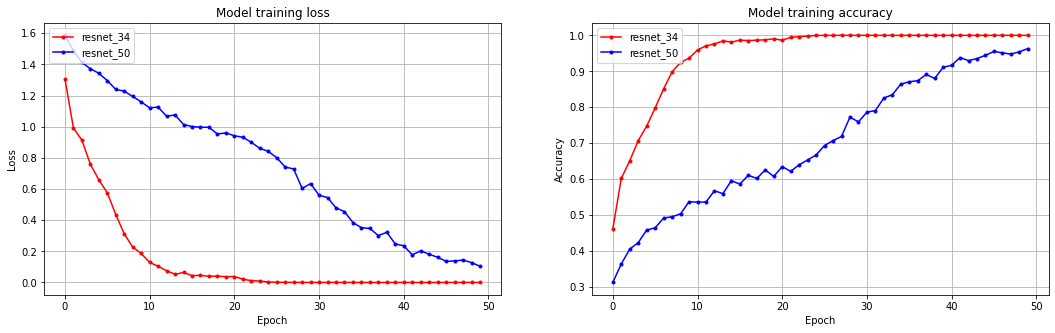

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history_34.history['loss'], marker='.', c='red')
plt.plot(resnet_history_50.history['loss'], marker='.', c='blue')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(resnet_history_34.history['accuracy'], marker='.', c='red')
plt.plot(resnet_history_50.history['accuracy'], marker='.', c='blue')
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.grid()

plt.show()

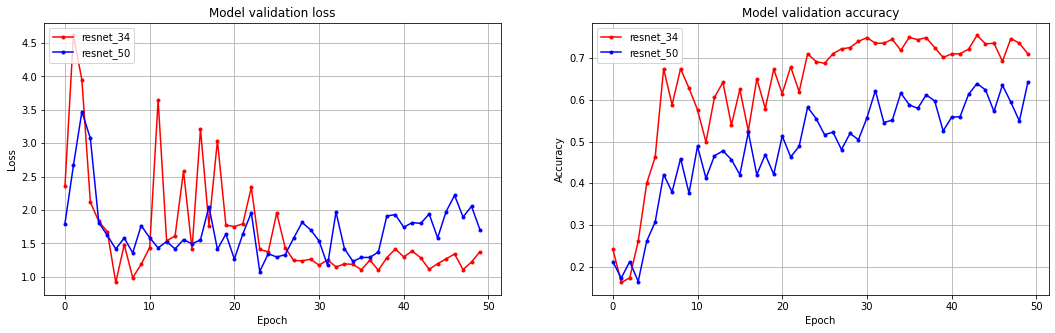

In [16]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(resnet_history_34.history['val_loss'], marker='.', c='red')
plt.plot(resnet_history_50.history['val_loss'], marker='.', c='blue')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(resnet_history_34.history['val_accuracy'], marker='.', c='red')
plt.plot(resnet_history_50.history['val_accuracy'], marker='.', c='blue')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.grid()

plt.show()

# Implementing plain network by Resnet paper

![](https://blackchopin.github.io/images/ResNet/1_6hF97Upuqg_LdsqWY6n_wg.png)

In [17]:
def build_plain_block(input_layer,
                    stride = 1,
                    layer_cnt=[3, 4, 6, 3], 
                    channel=[64, 128, 256, 512],
                    block_num=1,
                    is_50=False
                   ):
    # 입력 레이어
    x = input_layer


    if is_50 is False:
        # 34-layer conv2_x 반복 블록 시작
        strides = [stride] + [1] * (layer_cnt - 1)
        for stride in strides:

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides = stride
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides=1
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    else:
        # 50-layer conv2_x 반복 블록 시작
        strides = [stride] + [1] * (layer_cnt - 1)
        for stride in strides: 
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1, 1),
                padding='SAME',
                strides = stride
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3, 3),
                padding='SAME',
                strides=1
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)

            x = keras.layers.Conv2D(
                filters=4*channel,
                kernel_size=(1, 1),
                padding='SAME',
                strides = 1
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    return x

In [18]:
def build_plainnet(input_shape=(32, 32, 3), is_50=False):

    inputs = keras.layers.Input(shape=input_shape)

    # 공통 앞 부분 (conv1)
    x = keras.layers.Conv2D(64, 
                            kernel_size=7, 
                            padding='SAME', 
                            strides=2,
                            name='conv1_conv')(inputs)
    x = keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)

    # 공통 앞 부분 (conv2)
    x = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        name=f'conv2_pooling')(x)

    if is_50 is False :
        # resnet_34 구현
        strides = [1, 2, 2, 2]
        channel_cnt = [64, 128, 256, 512]
        layer_cnt = [3, 4, 6, 3]
        for i, (l_cnt, channel, stride) in enumerate(zip(layer_cnt, channel_cnt, strides)):
            x = build_plain_block(
                x,
                stride = stride,
                layer_cnt=l_cnt, 
                channel=channel,
                block_num=i,
                is_50=False
            )
    else:
        # resnet_50 구현
        strides = [2, 2, 2, 2]
        channel_cnt = [64, 128, 256, 512]
        layer_cnt = [3, 4, 6, 3]
        for i, (l_cnt, channel, stride) in enumerate(zip(layer_cnt, channel_cnt, strides)):
            x = build_plain_block(
                x,
                stride = stride,
                layer_cnt=l_cnt, 
                channel=channel,
                block_num=i,
                is_50=True
            )
    
    # 공통 출력 부분
    output = keras.layers.GlobalAveragePooling2D()(x)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(5, activation='softmax')(output)

    model = keras.Model(
        inputs=inputs,
        outputs=output
    )

    return model

In [19]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_pooling (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 55, 55, 64)        36928     
_________________________________________________________________
batch_normalization_87 (Batc (None, 55, 55, 64)        256 

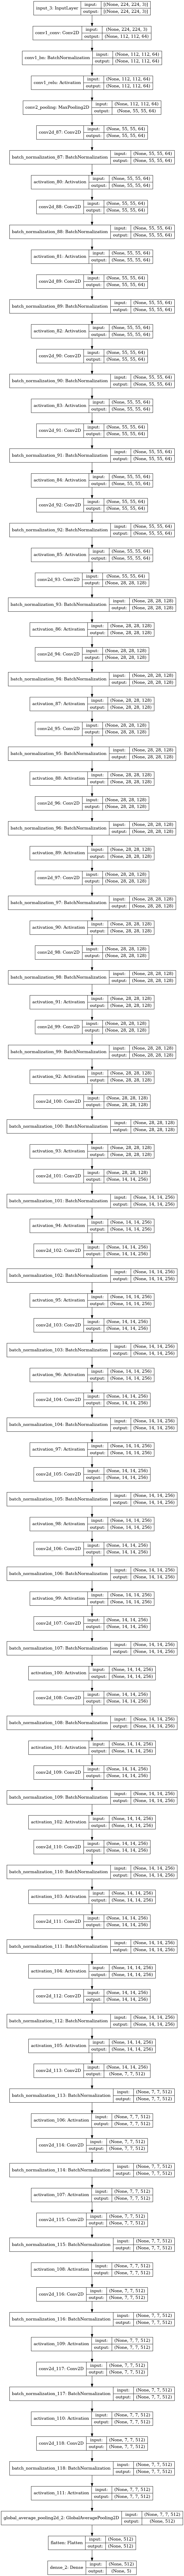

In [20]:
keras.utils.plot_model(plain_34, show_shapes=True)

In [21]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_pooling (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_119 (Bat (None, 28, 28, 64)        256 

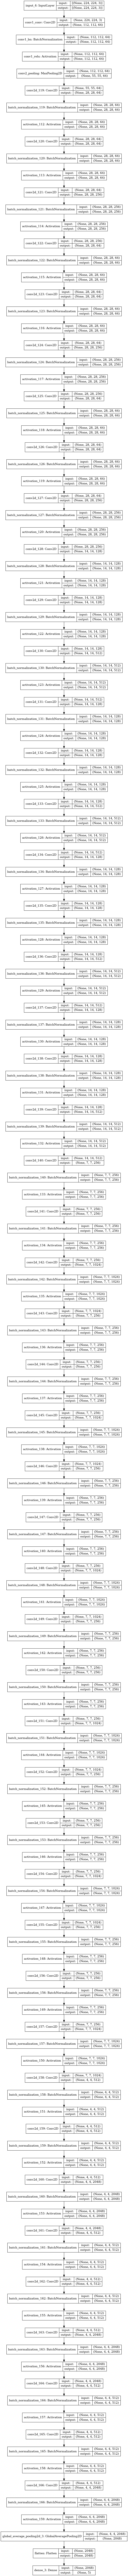

In [22]:
keras.utils.plot_model(plain_50, show_shapes=True)

In [23]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plainnet_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
91/91 [==============================] - 30s 230ms/step - loss: 1.5757 - accuracy: 0.3021 - val_loss: 1.7102 - val_accuracy: 0.1821
Epoch 2/50
91/91 [==============================] - 21s 228ms/step - loss: 1.5351 - accuracy: 0.3292 - val_loss: 2.3747 - val_accuracy: 0.2209
Epoch 3/50
91/91 [==============================] - 20s 225ms/step - loss: 1.5273 - accuracy: 0.3120 - val_loss: 3.3645 - val_accuracy: 0.2013
Epoch 4/50
91/91 [==============================] - 20s 225ms/step - loss: 1.5105 - accuracy: 0.3317 - val_loss: 3.6025 - val_accuracy: 0.2045
Epoch 5/50
91/91 [==============================] - 20s 225ms/step - loss: 1.5028 - accuracy: 0.3403 - val_loss: 2.9501 - val_accuracy: 0.1493
Epoch 6/50
91/91 [==============================] - 20s 226ms/step - loss: 1.4599 - accuracy: 0.3622 - val_loss: 1.8962 - val_accuracy: 0.2045
Epoch 7/50
91/91 [==============================] - 20s 225ms/step - loss: 1.3935 - accuracy: 0.3970 - val_loss: 1.8005 - val_accuracy: 0.3835

In [24]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plainnet_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
91/91 [==============================] - 26s 160ms/step - loss: 1.5826 - accuracy: 0.2889 - val_loss: 1.6387 - val_accuracy: 0.1989
Epoch 2/50
91/91 [==============================] - 14s 155ms/step - loss: 1.5732 - accuracy: 0.3084 - val_loss: 1.8094 - val_accuracy: 0.2159
Epoch 3/50
91/91 [==============================] - 14s 153ms/step - loss: 1.5587 - accuracy: 0.3178 - val_loss: 2.2625 - val_accuracy: 0.1612
Epoch 4/50
91/91 [==============================] - 14s 154ms/step - loss: 1.5414 - accuracy: 0.3201 - val_loss: 2.1636 - val_accuracy: 0.2188
Epoch 5/50
91/91 [==============================] - 14s 154ms/step - loss: 1.5316 - accuracy: 0.3351 - val_loss: 2.2279 - val_accuracy: 0.1894
Epoch 6/50
91/91 [==============================] - 14s 155ms/step - loss: 1.5364 - accuracy: 0.3263 - val_loss: 1.9327 - val_accuracy: 0.1851
Epoch 7/50
91/91 [==============================] - 14s 152ms/step - loss: 1.5360 - accuracy: 0.3291 - val_loss: 1.7136 - val_accuracy: 0.2484

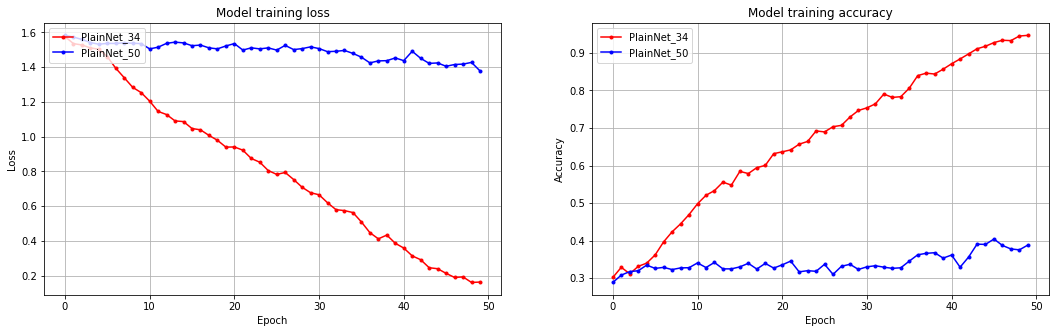

In [25]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_34.history['loss'], marker='.', c='red')
plt.plot(plainnet_history_50.history['loss'], marker='.', c='blue')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_34.history['accuracy'], marker='.', c='red')
plt.plot(plainnet_history_50.history['accuracy'], marker='.', c='blue')
plt.title('Model training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()

plt.show()

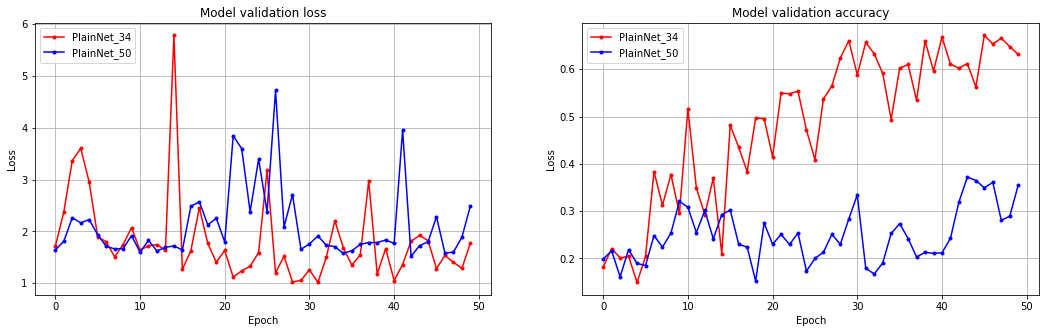

In [26]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_34.history['val_loss'], marker='.', c='red')
plt.plot(plainnet_history_50.history['val_loss'], marker='.', c='blue')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_34.history['val_accuracy'], marker='.', c='red')
plt.plot(plainnet_history_50.history['val_accuracy'], marker='.', c='blue')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'PlainNet_50'], loc='upper left')
plt.grid()

plt.show()

# Comaprison Resnet with PlainNet

## PlainNet-34 and ResNet-34

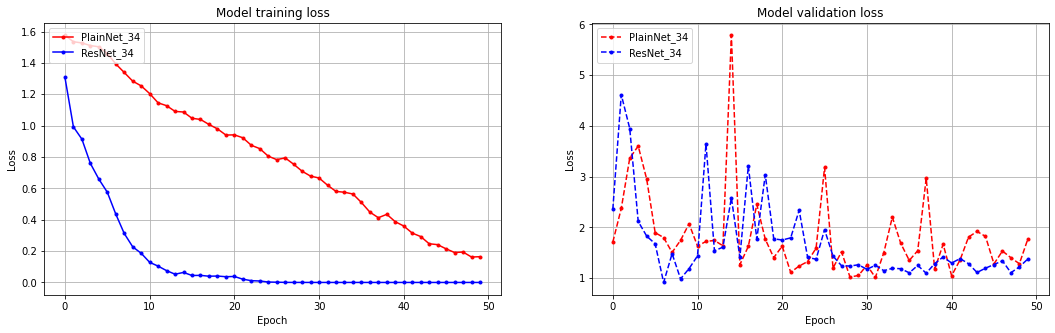

In [27]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_34.history['loss'], marker='.', c='red')
plt.plot(resnet_history_34.history['loss'], marker='.', c='blue')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'ResNet_34'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_34.history['val_loss'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_34.history['val_loss'], marker='.', c='blue', linestyle='dashed')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34', 'ResNet_34'], loc='upper left')
plt.grid()

plt.show()

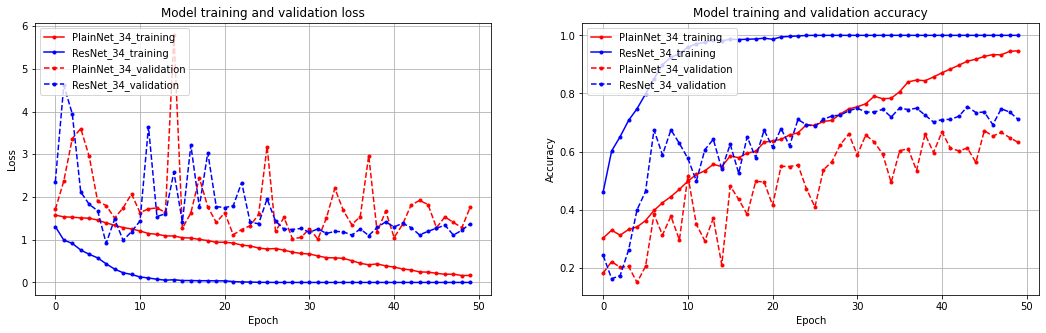

In [28]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_34.history['loss'], marker='.', c='red')
plt.plot(resnet_history_34.history['loss'], marker='.', c='blue')
plt.plot(plainnet_history_34.history['val_loss'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_34.history['val_loss'], marker='.', c='blue', linestyle='dashed')

plt.title('Model training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34_training', 'ResNet_34_training','PlainNet_34_validation', 'ResNet_34_validation'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_34.history['accuracy'], marker='.', c='red')
plt.plot(resnet_history_34.history['accuracy'], marker='.', c='blue')
plt.plot(plainnet_history_34.history['val_accuracy'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_34.history['val_accuracy'], marker='.', c='blue', linestyle='dashed')

plt.title('Model training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_34_training', 'ResNet_34_training','PlainNet_34_validation', 'ResNet_34_validation'], loc='upper left')
plt.grid()

plt.show()

## PlainNet-50 and ResNet-50

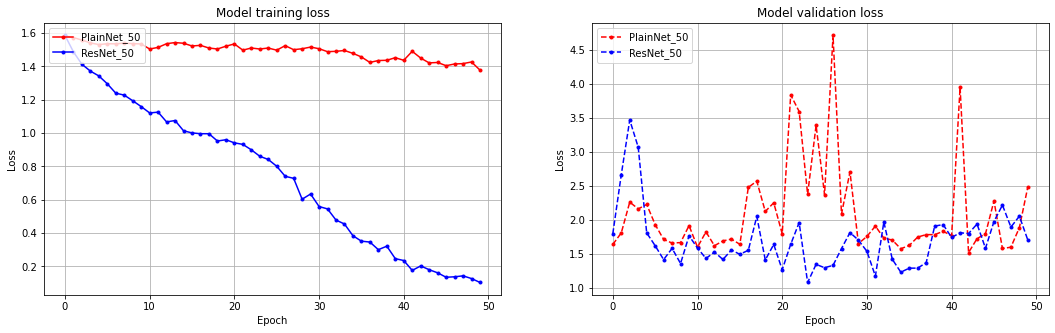

In [29]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_50.history['loss'], marker='.', c='red')
plt.plot(resnet_history_50.history['loss'], marker='.', c='blue')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50', 'ResNet_50'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_50.history['val_loss'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_50.history['val_loss'], marker='.', c='blue', linestyle='dashed')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50', 'ResNet_50'], loc='upper left')
plt.grid()

plt.show()

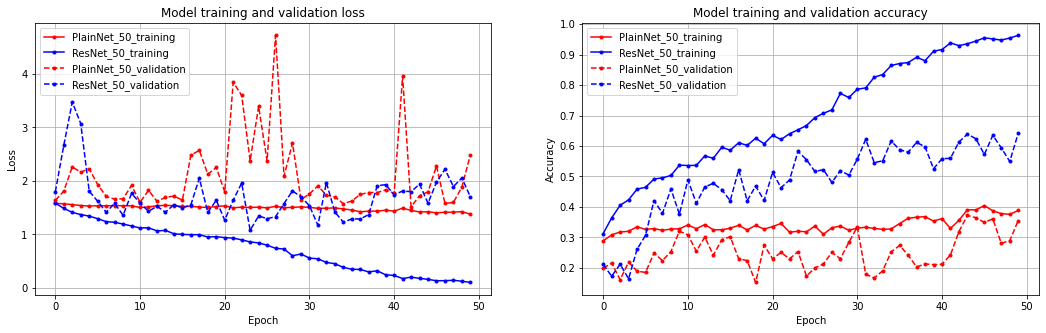

In [30]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(plainnet_history_50.history['loss'], marker='.', c='red')
plt.plot(resnet_history_50.history['loss'], marker='.', c='blue')
plt.plot(plainnet_history_50.history['val_loss'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_50.history['val_loss'], marker='.', c='blue', linestyle='dashed')

plt.title('Model training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50_training', 'ResNet_50_training','PlainNet_50_validation', 'ResNet_50_validation'], loc='upper left')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(plainnet_history_50.history['accuracy'], marker='.', c='red')
plt.plot(resnet_history_50.history['accuracy'], marker='.', c='blue')
plt.plot(plainnet_history_50.history['val_accuracy'], marker='.', c='red', linestyle='dashed')
plt.plot(resnet_history_50.history['val_accuracy'], marker='.', c='blue', linestyle='dashed')

plt.title('Model training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet_50_training', 'ResNet_50_training','PlainNet_50_validation', 'ResNet_50_validation'], loc='upper left')
plt.grid()


plt.show()


|평가문항||
|---|---|
|ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.|
|Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

### SkipConnection이 제거된 PlainNet과 비교하였을 때, ResNet의 동일한 epoch만큼 학습되었을 때 결과 비교

#### Validation Loss
|항목|10 epoch|20 epoch|30epoch|40epoch|50epoch|
|---|---|---|--|--|--|
|__ResNet-34__|1.1882|1.7750|1.2637|1.4175|__1.3778__||
|PlainNet-34|2.0710|1.4040|1.0528|1.6682|1.7715|
|__ResNet-50__|1.7670|1.6390|1.7032|1.9316|__1.7030__|
|PlainNet-50|1.9166|2.2529|1.6521|1.8324|2.4886|

### 50epoch 기준으로 ResNet의 Validaion loss와 Validaion Accuracy 모두 PlainNet보다 훨씬 개선됨을 확인할 수 있다.

#### Validaion Accuracy
|항목|10 epoch|20 epoch|30epoch|40epoch|50epoch|
|---|---|---|--|--|--|
|__ResNet-34__|0.2413|0.5751|0.6149|0.7492|__0.7102__|
|PlainNet-34|0.1820|0.5164|0.4150|0.5580|0.6676|
|__ResNet-50__|0.2119|0.4886|0.5134|0.5568|__0.5581__|
|PlainNet-50|0.2889|0.3409|0.3357|0.3304|0.3619|

In [48]:
for i, v in enumerate(resnet_history_50.history['val_loss']):
    if (i+1)%10==0:
        print(v)
    else:
        pass

1.767096757888794
1.639073371887207
1.703260064125061
1.9316291809082031
1.7030807733535767


In [49]:
for i, v in enumerate(plainnet_history_50.history['val_loss']):
    if (i+1)%10==0:
        print(v)
    else:
        pass

1.9166048765182495
2.2529067993164062
1.6521661281585693
1.8324902057647705
2.488687038421631
